# Normalised Mutual Information Calculation

- FROM: https://www.nature.com/articles/s41586-021-04206-7
- ALSO in:
    - https://doi.org/10.1016/j.ccell.2020.06.012

For the calculation of entropy and mutual information the Julia package InformationMeasures.jl was used.


First, for each cell X, gene expression was discretized into 10 bins.

Then, entropy (H) was calculated for each cell vector X where H is the entropy for cell X and p(xi) is the probability of cell X in bin i. 
```julia
get_entropy(cell_expression_vector; base = 2, number_of_bins = 10)
``` 
$$
H(X)=-\mathop{\sum }\limits_{i=1}^{n}p({x}_{i})\log p({x}_{i})
$$

Mutual information (MI) was then calculated for each cell pair where I is the mutual information for cell pair X;Y, p(x,y) is the joint probability of cell pair X and Y across all the bins, and p(x) and p(y) are the marginal probability of cell X and cell Y across all the bins, respectively.

```julia
get_mutual_information(cell_expression_vector1, cell_expression_vector2, base = 2, number_of_bins = 10)
```
$$
I(X;Y)=\sum _{y}\sum _{x}p(x,y)\log \,\frac{p(x,y)}{p(x)p(y)}
$$

Finally, Normalised Mutual Information (NMI) was calculated as pairwise MI divided by the entropy:

```julia
nmi = mi[x, y] / sqrt(h[x]*h[y])
```

$$
{\rm{NMI}}(X,Y)=\frac{I(X;Y)}{\sqrt{H(X)H(Y)}}
$$

To get robust results, we resampled 100 cells 100 times without replacement and summarized in box plots.

Where r is the number of comparisons in which the heterogeneity metrics in one group is at least as extreme as the one in another group and n is the total number of comparisons. Empirical p-value was calculated as

```julia
wt = subtb[subtb[!,:Genotype].=="WT", :NMI]
rad = subtb[subtb[!,:Genotype].=="RAD21", :NMI]
p = (sum(wt .< rad)+1)/((nrow(subtb)/2)+1)
```
$$
P=\frac{r+1}{n+1}
$$

p-value was also calculated using a two-sided Mann-Whitney U-test. 

# Phenotypic Volume

For PV analysis, the empirical covariance matrix was first generated from the scaled gene expression matrix. Singular value decomposition was then performed and the log of PV was calculated as the sum of the log of non-zero eigenvalues:

$$
\log (V)={\sum }_{e=1}^{E}\log ({\lambda }_{e}){({\lambda }_{e}{\rm{is}}{\rm{eigenvalue}},{\lambda }_{e} > 0)}^{2}.
$$

To do so, I translated the code in R from  https://atlassian.petermac.org.au/bitbucket/projects/DAW/repos/splintr_paper_code/browse/Fig_01_S5_S6_S7/scRNA_transcriptional_diversity_analysis.Rmd to julia where V is the phenotypic volume and λe is the non-zero eigenvalue. We then resampled 100 cells and 1,000 genes without replacement for 100 times. 


```julia
function scale(A)
    R"""a = scale($A)"""
    @rget a
end

function logPV(sceexp, cond; assay = "lnCPMplus1", permutations = 100, seed = 1223, cellssubsampled = 100,genesssubsampled = 1000)
    subsce = deepcopy(SingleCellExperiment.get_cells_with_this_characteristic(cond, :Sample, sceexp))
    dat = subsce.assays[assay]
    dat= transpose(dat) #feature on col, cell on row
    #remove non expressed genes
    bool = sum(dat, dims = 1).>0
    bool = reshape(bool,size(bool)[2])
    dat = dat[:,bool]
    dat = scale(dat)
    det = zeros(permutations)
    Random.seed!(seed)
    p = Progress(permutations, cond*": ")
    
   for ii in 1:permutations
        cellsample=shuffle(1:size(dat)[1])[1:cellssubsampled]
        genesample=shuffle(1:size(dat)[2])[1:genesssubsampled]
        dat = dat[cellsample,genesample]
        cdat = cov(dat)#calculate gene-gene covariance matrix using sampled genes
        svddat=svd(cdat) #singular value decomposition 
        eigen=svddat.S #get the eigen value 
        eigen=eigen[eigen.!=0]
        det[ii]= sum(log.(eigen)) #log sum of non-zero eigen values
        next!(p)
    end
    det
end
```

P values where calculated as NMI


In [7]:
ENV["Code"] = "../../Code"
for folder in readdir(ENV["Code"]); push!(LOAD_PATH, normpath(ENV["Code"], folder));end

using Seaborn, PyPlot, PyCall, DataFrames
using NoLongerProblems_Pandas, Pandas
using MultipleTesting, HypothesisTests 
using SingleCellExperiment, StatsBase
using ProgressMeter, Random, ProgressMeter
using RCall, LinearAlgebra
using Statistics

using InformationMeasures
using CSV, ProgressMeter,PrettyPlotting, ScikitLearn
@sk_import linear_model: LogisticRegression

include("../Databases/Cuartero2018.jl")
include("../Databases/Bhatt2012.jl")
include("../Databases/MF_SingleCell.jl")
include("NMIFunctions.jl")
include("PhenotypicVolume.jl")

PV_figure (generic function with 1 method)

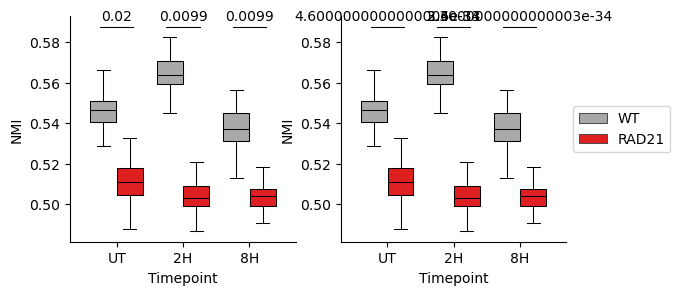

0.019801980198019802
0.009900990099009901
0.009900990099009901
4.593944365706254e-33
2.5621436691633854e-34
3.2576821808361335e-34


In [21]:
include("../Code/Load_scRNAseqData.jl")
sce = SingleCellExperiment.get_cells_with_this_characteristics(["WT", "RAD21"], :Genotype, sce)
sce = SingleCellExperiment.select_expressed_genes(sce; min_cells_expressing_gene = 3)
sce = SingleCellExperiment.fit_mu_std_alpha(sce, splitdataby = :Sample, assay = "CPM")
tb = NMI_table(sce)
subplot(1,2,1)
NMI_figure(tb, pvalue_ = :option1)
legend_removal()
subplot(1,2,2)
NMI_figure(tb, pvalue_ = :option2)
legend_out_of_plot()
savefigwithtext("SingleCell_NMI.svg")
savefigwithtext("SingleCell_NMI.png")

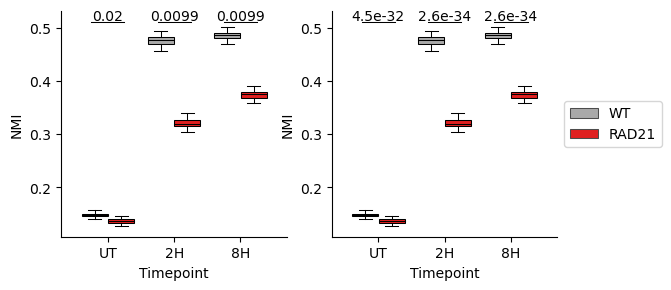

0.019801980198019802
0.009900990099009901
0.009900990099009901
4.493869376599482e-32
2.5621436691633854e-34
2.561999346290046e-34


In [9]:
include("../Code/Load_scRNAseqData.jl")
sce = SingleCellExperiment.get_cells_with_this_characteristics(["WT", "RAD21"], :Genotype, sce)
sce = SingleCellExperiment.fit_mu_std_alpha(sce, splitdataby = :Sample, assay = "CPM")
bhattgenes = Bhatt2012.inducible_genes_figure3()[!,:GeneSymbol];
sce = SingleCellExperiment.select_these_genes(bhattgenes, sce)
tb = NMI_table(sce)
subplot(1,2,1)
NMI_figure(tb, pvalue_ = :option1, u = 0.01)
legend_removal()
subplot(1,2,2)
NMI_figure(tb, pvalue_ = :option2, u = 0.01)
legend_out_of_plot()
savefigwithtext("SingleCell_NMIBhatt.svg")
savefigwithtext("SingleCell_NMIBhatt.png")

WT_UT: 100%|████████████████████████████████████████████| Time: 0:00:10
WT_2H: 100%|████████████████████████████████████████████| Time: 0:00:09
WT_8H: 100%|████████████████████████████████████████████| Time: 0:00:09
RAD21_UT: 100%|█████████████████████████████████████████| Time: 0:00:10
RAD21_2H: 100%|█████████████████████████████████████████| Time: 0:00:10
RAD21_8H: 100%|█████████████████████████████████████████| Time: 0:00:10


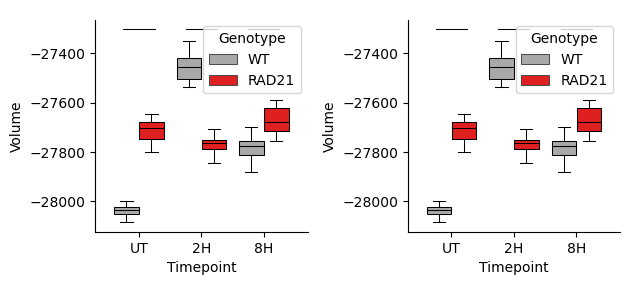

0.0196078431372549
0.0196078431372549
0.058823529411764705
7.066071930388952e-18
7.066071930388952e-18
9.377214427359579e-16


In [28]:
include("../Code/Load_scRNAseqData.jl")
sce = SingleCellExperiment.get_cells_with_this_characteristics(["WT", "RAD21"], :Genotype, sce)
sce = SingleCellExperiment.select_expressed_genes(sce; min_cells_expressing_gene = 100)
assay = "lnCPMplus1" # In the paper they use the logcounts
perm = 50

function logPV(sceexp, cond; assay = "lnCPMplus1", permutations = 100, seed = 1223, cellssubsampled = 150,genesssubsampled = 1000)
    subsce = deepcopy(SingleCellExperiment.get_cells_with_this_characteristic(cond, :Sample, sceexp))
    dat = subsce.assays[assay]
    dat= transpose(dat) #feature on col, cell on row
    #remove non expressed genes
    bool = sum(dat, dims = 1).>0
    bool = reshape(bool,size(bool)[2])
    dat = dat[:,bool]
    dat = scale(dat)
    det = zeros(permutations)
    Random.seed!(seed)
    p = Progress(permutations, cond*": ")
    
   for ii in 1:permutations
        cellsample=shuffle(1:size(dat)[1])[1:cellssubsampled]
        genesample=shuffle(1:size(dat)[2])[1:genesssubsampled]
        dat = dat[cellsample,genesample]
        cdat = cov(dat)#calculate gene-gene covariance matrix using sampled genes
        svddat=svd(cdat) #singular value decomposition 
        eigen=svddat.S #get the eigen value 
        eigen=eigen[eigen.!=0]
        det[ii]= sum(log.(eigen)) #log sum of non-zero eigen values
        next!(p)
    end
    det
end

df = DataFrames.DataFrame(
    WT_UT = logPV(sce, "WT_UT", assay = assay, permutations = perm),
    WT_2H = logPV(sce, "WT_2H", assay = assay, permutations = perm),
    WT_8H = logPV(sce, "WT_8H", assay = assay, permutations = perm),
    RAD21_UT = logPV(sce, "RAD21_UT", assay = assay, permutations = perm),
    RAD21_2H = logPV(sce, "RAD21_2H", assay = assay, permutations = perm),
    RAD21_8H = logPV(sce, "RAD21_8H", assay = assay, permutations = perm),
)
stdf = DataFrames.stack(df, [:WT_UT, :RAD21_UT, :WT_2H, :RAD21_2H, :WT_8H, :RAD21_8H],)
rename!(stdf, "variable"=>"Sample", "value" =>"Volume")
stdf[!,:Genotype] = [split(ii, "_")[1] for ii in stdf[!,:Sample]]
stdf[!,:Timepoint] = [split(ii, "_")[2] for ii in stdf[!,:Sample]]

subplot(1,2,1)
PV_figure(stdf, "Volume", u = 50,  pvalue_ = :option1)
subplot(1,2,2)
PV_figure(stdf, "Volume", u = 50,  pvalue_ = :option2)
plt.tight_layout()

In [23]:
include("../Code/Load_scRNAseqData.jl")
sce = SingleCellExperiment.get_cells_with_this_characteristics(["WT", "RAD21"], :Genotype, sce)
sce = SingleCellExperiment.fit_mu_std_alpha(sce, splitdataby = :Sample, assay = "CPM")
sce = SingleCellExperiment.select_expressed_genes(sce; min_cells_expressing_gene = 3)
bhattgenes = Bhatt2012.inducible_genes_figure3()[!,:GeneSymbol];
sce = SingleCellExperiment.select_these_genes(bhattgenes, sce)
perm = 50
df = DataFrames.DataFrame(
    WT_UT = logPV(sce, "WT_UT", assay = assay, permutations = perm),
    WT_2H = logPV(sce, "WT_2H", assay = assay, permutations = perm),
    WT_8H = logPV(sce, "WT_8H", assay = assay, permutations = perm),
    RAD21_UT = logPV(sce, "RAD21_UT", assay = assay, permutations = perm),
    RAD21_2H = logPV(sce, "RAD21_2H", assay = assay, permutations = perm),
    RAD21_8H = logPV(sce, "RAD21_8H", assay = assay, permutations = perm),
)
stdf = DataFrames.stack(df, [:WT_UT, :RAD21_UT, :WT_2H, :RAD21_2H, :WT_8H, :RAD21_8H],)
rename!(stdf, "variable"=>"Sample", "value" =>"Volume")
stdf[!,:Genotype] = [split(ii, "_")[1] for ii in stdf[!,:Sample]]
stdf[!,:Timepoint] = [split(ii, "_")[2] for ii in stdf[!,:Sample]]

subplot(1,2,1)
PV_figure(stdf, "Volume", u = 50,  pvalue_ = :option1)
subplot(1,2,2)
PV_figure(stdf, "Volume", u = 50,  pvalue_ = :option2)

LoadError: BoundsError: attempt to access 476-element Vector{Int64} at index [1:1000]

In [12]:
import Pkg
Pkg.status()

      Status `~/.julia/environments/v1.6/Project.toml`
  [7e6ae17a] BioSequences v2.0.5
  [336ed68f] CSV v0.9.11
  [8f4d0f93] Conda v1.5.2
  [a93c6f00] DataFrames v1.2.2
  [31c24e10] Distributions v0.25.28
  [c2308a5c] FASTX v1.2.0
  [09f84164] HypothesisTests v0.10.6
  [7073ff75] IJulia v1.23.2
  [916415d5] Images v0.24.1
  [96684042] InformationMeasures v0.3.1
  [f8716d33] MultipleTesting v0.5.0
  [92933f4c] ProgressMeter v1.7.1
  [438e738f] PyCall v1.92.5
  [d330b81b] PyPlot v2.10.0
  [6f49c342] RCall v0.13.12
  [d2ef9438] Seaborn v1.0.0
  [2913bbd2] StatsBase v0.33.13


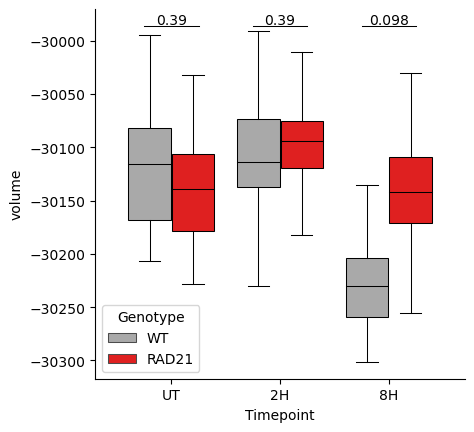

0.39215686274509803
0.39215686274509803
0.09803921568627451


In [24]:
tb = CSV.read("PV.csv", DataFrames.DataFrame)
tb[!,:Sample] = tb[!,:cell]

    sg = [split(ii, "_") for ii in tb[!,:Sample]]
    tb[!,:Genotype] = [ii[1] for ii in sg]
    tb[!,:Timepoint] = [ii[2] for ii in sg]

PV_figure(tb, "volume", u = 5,  pvalue_ = :option1)

In [ ]:
function logPV(sceexp, cond; assay = "lnCPMplus1", permutations = 100, seed = 1223, cellssubsampled = 100,genesssubsampled = 1000)
    subsce = deepcopy(SingleCellExperiment.get_cells_with_this_characteristic(cond, :Sample, sceexp))
    dat = subsce.assays[assay]
    dat= transpose(dat) #feature on col, cell on row
    #remove non expressed genes
    #bool = sum(dat, dims = 1).>0
    #bool = reshape(bool,size(bool)[2])
    #dat = dat[:,bool]
    dat = scale(dat)
    det = zeros(permutations)
    Random.seed!(seed)
    p = Progress(permutations, cond*": ")
    
   for ii in 1:permutations
        cellsample=shuffle(1:size(dat)[1])[1:cellssubsampled]
        genesample=shuffle(1:size(dat)[2])[1:genesssubsampled]
        dat = dat[cellsample,genesample]
        cdat = cov(dat)#calculate gene-gene covariance matrix using sampled genes
        svddat=svd(cdat) #singular value decomposition 
        eigen=svddat.S #get the eigen value 
        eigen=eigen[eigen.!=0]
        det[ii]= sum(log.(eigen)) #log sum of non-zero eigen values
        next!(p)
    end
    det
end












"""testCovgene <- function(cond) {
    sub_meta=subset(meta, Sample == cond)
    dat=exp[ , match(rownames(sub_meta), colnames(exp))]
    dat=t(dat) #feature on col, cell on row
    dat=scale(dat) #standadize data scale by col/feature
    print(cond)
    det=list()
    for (i in 1:50){ #permutation 
    set.seed(i)
    cellsample=sample(1:nrow(dat),100, replace=F) #sample cells to keep the same number of cell for both comb and kras

    genesample=sample(1:ncol(dat), 1000, replace=F) #take long time to run so could sample genes, I also tried with all genes and it shows similar trend but bigger difference 

    cdat = cov(dat[cellsample,genesample]) #calculate gene-gene covariance matrix using sampled genes
    #cdat = cov(dat[cellsample,genesample]) #calculate gene-gene covariance matrix using all genes 
    
    svddat=svd(cdat) #singular value decomposition 

    eigen=svddat$d #get the eigen value 

    eigen=eigen[eigen!=0]

    logV=sum(log(eigen)) #log sum of non-zero eigen values
#    logV=logV/length(genesample) #you could also norm by total number of genes 
    print(logV)
    det[[i]]=logV
    }

    return(det)
}"""

